In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from tensorflow.keras import regularizers


In [2]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')
train_data.head()

,matchId,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome
0,m_91,p_103,جریان بازی,پای راست,13.47,-11.22,1,0,متوسط,70,9,گُل
1,m_17,p_16,جریان بازی,پای چپ,9.48,14.22,3,0,متوسط,55,4,مهار توسط دروازه بان
2,m_111,p_88,ضربه آزاد مستقیم,پای چپ,29.43,-1.25,6,2,کم,86,31,مهار توسط دروازه بان
3,m_142,p_87,جریان بازی,پای راست,26.93,1.00,4,1,متوسط,77,2,موقعیت از دست رفته
4,m_117,p_9,جریان بازی,پای راست,10.72,5.24,2,0,متوسط,76,46,گُل


In [3]:
train_data.drop(['matchId', 'playerId', 'second'],axis=1,inplace=True)
test_data.drop([ 'second'],axis=1,inplace=True)

## replace missing values

In [4]:
def imputer(data):
    imp_mean = SimpleImputer(missing_values=float('nan'), strategy="most_frequent")
    imp_mean.fit(data)
    imputed_data=pd.DataFrame(imp_mean.transform(data))
    imputed_data.columns=data.columns
    imputed_data.index=data.index
    return imputed_data

train_data=imputer(train_data)
test_data=imputer(test_data)

## add new fetuers

In [5]:
def add_distance(data):
    X=np.array(data.x).astype(float)
    y=np.array(data.y).astype(float)
    distance=np.round(np.sqrt((X**2+y**2)))
    return distance

train_data['distance']=add_distance(train_data)
test_data['distance']=add_distance(test_data)

In [6]:
goal_line_width = 7.32

def add_anlge(data):
    X=np.array(data.x).astype(float)
    y=np.array(data.y).astype(float)
    angle=np.arctan(goal_line_width*X/(X**2+y**2-(goal_line_width/2)**2))
    to_degree=np.vectorize(lambda alpha: np.pi + alpha if alpha < 0 else alpha)

    angle=np.rad2deg(to_degree(angle))
    return angle
train_data['angle']=add_anlge(train_data)
test_data['angle']=add_anlge(test_data)
    
    

In [7]:
train_data.outcome.unique()

array(['گُل', 'مهار توسط دروازه بان', 'موقعیت از دست رفته',
       'برخورد به دفاع', 'برخورد به تیردروازه', 'گُل به خودی'],
      dtype=object)

In [8]:
train_data.interferenceOnShooter.unique()

array(['متوسط', 'کم', 'زیاد'], dtype=object)

In [9]:
train_data['outcome']=  (train_data.outcome=='گُل')  |(train_data.outcome=='گُل به خودی')
train_data['outcome']=train_data['outcome'].astype(float)

In [10]:

for col in ['interferenceOnShooter','playType' ,'bodyPart']:
    enc=preprocessing.LabelEncoder()

    train_data[col]=enc.fit_transform(np.array(train_data[col]).reshape(-1, 1))
    test_data[col]=enc.transform(np.array(test_data[col]).reshape(-1, 1))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [11]:
train_data.head()

,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,outcome,distance,angle
0,0,2,13.47,-11.22,1,0,1,70,1.0,18.0,18.544088
1,0,3,9.48,14.22,3,0,1,55,0.0,17.0,13.982592
2,1,3,29.43,-1.25,6,2,2,86,0.0,29.0,14.153255
3,0,2,26.93,1,4,1,1,77,0.0,27.0,15.458384
4,0,2,10.72,5.24,2,0,1,76,1.0,12.0,31.315918


In [12]:
X=train_data.drop(labels='outcome',axis=1)
y=pd.DataFrame()
y['outcome']=train_data['outcome']

In [13]:
scaler = preprocessing.MinMaxScaler().fit(X)
X=pd.DataFrame(scaler.transform(X))
test_data=pd.DataFrame(scaler.transform(test_data))

In [14]:
X_train, X_val,  y_train, y_val = train_test_split( X, y, test_size=0.1, shuffle=True,random_state=42)

In [15]:
test_data.shape[0]==pd.read_csv('test.csv').shape[0]


True

In [16]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation,BatchNormalization
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [17]:
model = Sequential()
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
# model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))


In [18]:
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])
history = model.fit(np.array(X_train), np.array(y_train),validation_split=0.1, batch_size=16, epochs=63)


Epoch 1/63
502/502 [==============================] - 2s 2ms/step - loss: 0.1516 - accuracy: 0.8586 - val_loss: 0.0950 - val_accuracy: 0.8835
Epoch 2/63
502/502 [==============================] - 1s 2ms/step - loss: 0.0948 - accuracy: 0.8854 - val_loss: 0.0908 - val_accuracy: 0.8925
Epoch 3/63
502/502 [==============================] - 1s 3ms/step - loss: 0.0934 - accuracy: 0.8830 - val_loss: 0.0888 - val_accuracy: 0.8925
Epoch 4/63
502/502 [==============================] - 1s 2ms/step - loss: 0.0919 - accuracy: 0.8857 - val_loss: 0.0889 - val_accuracy: 0.8936
Epoch 5/63
502/502 [==============================] - 1s 2ms/step - loss: 0.0925 - accuracy: 0.8865 - val_loss: 0.0885 - val_accuracy: 0.8936
Epoch 6/63
502/502 [==============================] - 1s 2ms/step - loss: 0.0919 - accuracy: 0.8861 - val_loss: 0.0878 - val_accuracy: 0.8925
Epoch 7/63
502/502 [==============================] - 1s 2ms/step - loss: 0.0868 - accuracy: 0.8907 - val_loss: 0.0879 - val_accuracy: 0.8959
Epoch 

502/502 [==============================] - 2s 3ms/step - loss: 0.0885 - accuracy: 0.8837 - val_loss: 0.0892 - val_accuracy: 0.8925
Epoch 59/63
502/502 [==============================] - 1s 3ms/step - loss: 0.0843 - accuracy: 0.8938 - val_loss: 0.0876 - val_accuracy: 0.8936
Epoch 60/63
502/502 [==============================] - 1s 3ms/step - loss: 0.0901 - accuracy: 0.8839 - val_loss: 0.0903 - val_accuracy: 0.8925
Epoch 61/63
502/502 [==============================] - 1s 2ms/step - loss: 0.0894 - accuracy: 0.8865 - val_loss: 0.0903 - val_accuracy: 0.8947
Epoch 62/63
502/502 [==============================] - 1s 2ms/step - loss: 0.0865 - accuracy: 0.8909 - val_loss: 0.0883 - val_accuracy: 0.8936
Epoch 63/63
502/502 [==============================] - 1s 2ms/step - loss: 0.0907 - accuracy: 0.8823 - val_loss: 0.0900 - val_accuracy: 0.8914


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


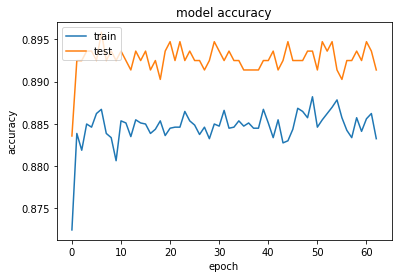

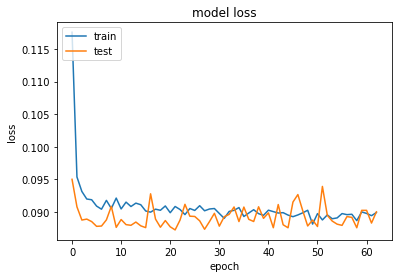

In [19]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## mlp is beter than other ml models

In [22]:

model.evaluate(X_val,y_val)


28/28 [==============================] - 0s 993us/step - loss: 0.0900 - accuracy: 0.8914


[0.09002432972192764, 0.8913773894309998]